In [5]:
#If th openai api key is not set already, please set it here.
import os
if 'OPENAI_API_KEY' not in os.environ:  
     os.environ['OPENAI_API_KEY'] = 'your key'

In [6]:
from amadeusgpt import AMADEUS
from amadeusgpt.config import Config
import amadeusgpt
from amadeusgpt.utils import parse_result
from pathlib import Path
import matplotlib.pyplot as plt
import cv2

In [7]:
amadeus_root = Path(amadeusgpt.__file__).parent.parent
config = Config(amadeus_root / "amadeusgpt/configs/MABe_template.yaml")
config['data_info']['data_folder'] = amadeus_root / config['data_info']['data_folder']

amadeus = AMADEUS(config)
video_file_paths = amadeus.get_video_file_paths()
print (video_file_paths)

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


current total cost 0.0041 $
current input tokens 8666
current accumulated tokens 26382
description of the image frame provided
The image shows a top view of a small enclosure with several small animals moving around. The animals appear to be mice, as indicated by their size and shape. The background is filled with a light-colored substrate, likely bedding material, which creates a contrast with the darker color of the mice. 

Based on this observation, I can fill in the JSON string as follows:

```json
{
    "description": "A top view of a small enclosure with several mice moving around on a light-colored substrate.",
    "individuals": 3,
    "species": "topview_mouse",
    "background_objects": ["bedding material"]
}
```
['/Users/shaokaiye/AmadeusGPT-dev/examples/MABe/EGS8X2MN4SSUGFWAV976.mp4']


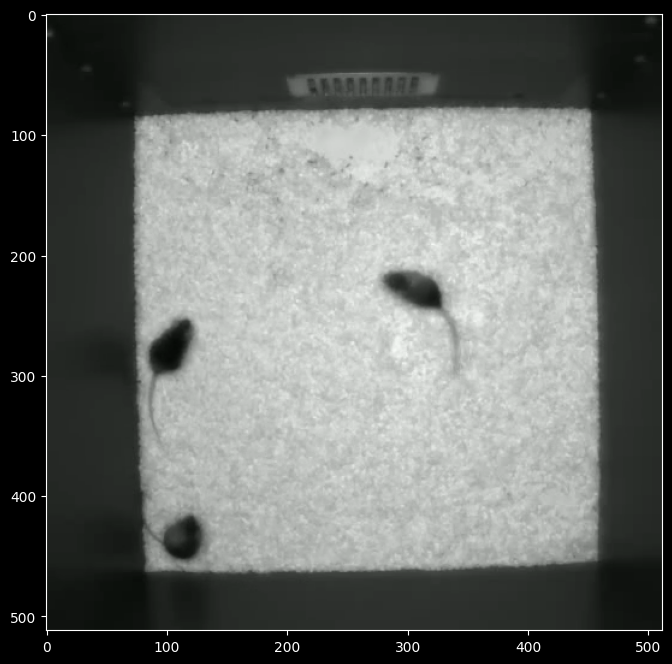

In [8]:
behavior_analysis = amadeus.get_behavior_analysis('/Users/shaokaiye/AmadeusGPT-dev/examples/MABe/EGS8X2MN4SSUGFWAV976.mp4')
scene_image = behavior_analysis.visual_manager.get_scene_image()
plt.imshow(scene_image)

In [14]:
query = "Define watch as a social behavior where distance between animals is less than 260  \
and larger than 50 and head angle between animals is less than 15. The smooth_window_size is 15. Get watching"
qa_message = amadeus.step(query)
qa_message = parse_result(amadeus, qa_message)

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"


doing active forgetting


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


current total cost 0.0069 $
current input tokens 2829
current accumulated tokens 39222


To define the "watching" behavior based on the distance between animals and a treadmill, as well as the head angle between animals, we will need to adjust our approach slightly. 

Here are the criteria for the "watching" behavior:

1. The distance between animals and the treadmill is less than 260 and greater than 50.
2. The relative head angle between animals is less than 15 degrees.

Since we need to interact with an object (the treadmill), we will use the `get_animals_object_events` function to capture the distance events. 

Here’s how we can implement this:

```python
def get_watching_events(identifier):
    '''
    Parameters:
    ----------
    identifier: Identifier. Contains information about the video, keypoint and config
    
    Returns:
    -------
    List[Event]: Events where animals are watching each other based on defined criteria.
    '''
    # create_analysis returns an instance of AnimalBehaviorAnalysis
    analysis = create_analysis(identifier)
    
    # Define the queries for distance to the treadmill
    distance_query = 'distance<260'
    negate_distance = False  # We want to include distances less than 260
    bodypart_names = None  # We consider all bodyparts for the animals
    
    # Get events for distance to the treadmill
    distance_events = analysis.get_animals_object_events(object_name='treadmill',
                                                          query=distance_query,
                                                          negate=negate_distance,
                                                          bodypart_names=bodypart_names,
                                                          min_window=11,
                                                          max_window=100000,
                                                          smooth_window_size=15)
    
    # Now we need to filter for distances greater than 50
    distance_events_greater_than_50 = analysis.get_animals_object_events(object_name='treadmill',
                                                                          query='distance>50',
                                                                          negate=negate_distance,
                                                                          bodypart_names=bodypart_names,
                                                                          min_window=11,
                                                                          max_window=100000,
                                                                          smooth_window_size=15)
    
    # Define the query for head angle
    head_angle_query = ['relative_head_angle<15']
    
    # Get events for head angle
    head_angle_events = analysis.get_animals_animals_events(cross_animal_query_list=head_angle_query,
                                                             min_window=11, 
                                                             max_window=100000,
                                                             smooth_window_size=15)
    
    # Combine the distance events (both conditions) using logical AND
    combined_distance_events = analysis.get_composite_events(distance_events,
                                                             distance_events_greater_than_50,
                                                             composition_type="logical_and",
                                                             max_interval_between_sequential_events=15,
                                                             min_window=11,
                                                             max_window=100000)
    
    # Combine the distance events with head angle events using logical AND
    watching_events = analysis.get_composite_events(combined_distance_events,
                                                     head_angle_events,
                                                     composition_type="logical_and",
                                                     max_interval_between_sequential_events=15,
                                                     min_window=11,
                                                     max_window=100000)
    
    return watching_events
```

This function captures the "watching" behavior based on the specified criteria involving the treadmill and the relative head angle between animals, returning the relevant events.

[]

### You can get a list of binary masks (equivalent to ethogram) for the underlying behavior, if your query is about retriving a described behavior

In [11]:
# the return masks is of shape (num_of_events, video_length)
# where each boolean array of (video_length,) is binary where True indicates whether the behavior is happening at that frame
masks = qa_message.get_masks()
print (masks)

{'/Users/shaokaiye/AmadeusGPT-dev/examples/MABe/EGS8X2MN4SSUGFWAV976.mp4': array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])}
